In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from tqdm import tqdm
from nltk.corpus import stopwords
stopwordEn = stopwords.words('english')
from nltk.corpus import wordnet
import pickle
import multiprocessing as mp

print('CPU numbers:',mp.cpu_count())
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)
def apply_by_multiprocessing(df, func, **kwargs):
#     print(kwargs)
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
#apply_by_multiprocessing(fullset['Text'], process_text, workers=cores)
def lemmaWord(word):
    lemma = wordnet.morphy(word)
    if lemma is not None:
        return lemma
    else:
        return word
def processText(text,lemma=False, gram=1):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    tokens = word_tokenize(text)
    tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if i.lower() not in stopwordEn and i.isalpha()]
    if gram<=1:
        return tokens
    else:
        return [i for i in nltk.ngrams(tokens, gram)]

CPU numbers: 32


In [2]:
dates = range(23,30)
news_words_dicts, news_words_dicts_2g, tweets_words_dicts, tweets_words_dicts_2g={},{},{},{}
# t = 'new'
t = 'unique'
for d in tqdm(dates):
    with open('./IEEE_news/data_032329_{}/words_dict_03{}_lemma.pickle'.format(t,d), 'rb') as handle:
        news_words_dicts[d] = pickle.load(handle)
    with open('./IEEE_news/data_032329_{}/words_dict_2g_03{}_lemma.pickle'.format(t,d), 'rb') as handle:
        news_words_dicts_2g[d] = pickle.load(handle)
    with open('./IEEE_tweets/data_032329_{}/words_dict_03{}_lemma.pickle'.format(t,d), 'rb') as handle:
        tweets_words_dicts[d] = pickle.load(handle)
    with open('./IEEE_tweets/data_032329_{}/words_dict_2g_03{}_lemma.pickle'.format(t,d), 'rb') as handle:
        tweets_words_dicts_2g[d] = pickle.load(handle)

100%|██████████| 7/7 [00:02<00:00,  2.33it/s]


# List one-week top common words

##  1-gram 

In [198]:
# News
dfs = [pd.DataFrame(news_words_dicts[d].most_common(30),columns=['Mar_{} '.format(d),'counts_{}'.format(d)]) for d in dates]
df_words_dict = pd.concat(dfs,axis=1)
df_words_dict.head(10)

,Mar_23,counts_23,Mar_24,counts_24,Mar_25,counts_25,Mar_26,counts_26,Mar_27,counts_27,Mar_28,counts_28,Mar_29,counts_29
0,say,340207,say,391917,say,406257,say,381762,say,356648,say,250462,say,154912
1,coronavirus,221331,coronavirus,229884,coronavirus,237220,coronavirus,227030,coronavirus,217655,coronavirus,145210,coronavirus,90965
2,people,174412,people,191747,people,193330,people,182372,people,172662,people,121127,people,79957
3,health,132603,health,145644,health,148542,new,139984,new,133520,new,94337,new,60696
4,new,120261,new,133713,new,141641,health,135300,health,130593,health,88293,state,54336
5,also,117494,also,124019,also,129265,also,127243,also,119106,state,82401,health,53943
6,march,114979,march,122597,state,123651,state,126610,state,114582,case,73395,case,48493
7,state,108597,state,118632,march,122445,march,121712,march,113584,also,72897,also,47454
8,home,95211,home,105091,home,106000,would,101052,one,98273,march,69145,one,42372
9,case,95006,need,101870,one,105676,one,100904,case,97346,one,67431,home,41128


In [199]:
# Tweets
dfs = [pd.DataFrame(tweets_words_dicts[d].most_common(30),columns=['Mar_{} '.format(d),'counts_{}'.format(d)]) for d in dates]
df_words_dict = pd.concat(dfs,axis=1)
df_words_dict.head(10)

,Mar_23,counts_23,Mar_24,counts_24,Mar_25,counts_25,Mar_26,counts_26,Mar_27,counts_27,Mar_28,counts_28,Mar_29,counts_29
0,corona,277336,corona,305240,corona,274156,corona,279575,corona,440836,corona,246104,corona,93171
1,virus,97373,virus,107134,virus,92678,virus,94814,virus,147465,virus,78107,virus,29585
2,people,35113,get,36873,get,35851,get,35338,get,54718,get,29199,people,11373
3,get,33395,people,36276,people,31182,people,31835,people,50423,people,29164,get,10517
4,like,22078,like,23965,like,20552,like,20925,like,31716,like,17833,amp,7275
5,go,19980,go,20780,go,19095,go,19122,go,29262,amp,17744,like,7039
6,amp,18766,amp,20757,amp,18239,amp,18836,us,29045,go,15943,go,5879
7,us,18234,stay,19768,us,18084,us,18620,amp,28785,us,14871,us,5499
8,stay,17387,us,19367,coronavirus,17286,coronavirus,17917,coronavirus,28329,one,14627,time,5402
9,please,17303,home,18312,time,15858,time,16315,one,25507,coronavirus,13551,one,5287


In [11]:
i=1000
from scipy import stats

stats.mannwhitneyu(list(tweets_words_dicts[d].keys())[:i],list(news_words_dicts[d].keys())[:i],alternative='two-sided')

MannwhitneyuResult(statistic=484877.0, pvalue=0.24156211969665764)

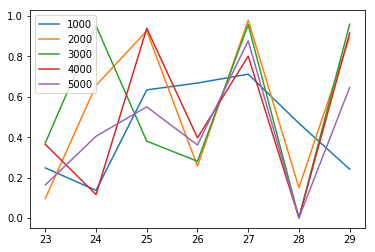

In [200]:
# Mann-Whitney U test for each day
# 分别看每一天的U-test,在不同大小的top子集上，可发现最前面（freq）的词语rank相类似，后续词语不同
from scipy import stats
mw = {}
for i in range(1000,6000,1000):
    u_test=[]
    for d in dates:
        u_test.append(stats.mannwhitneyu(list(tweets_words_dicts[d].keys())[:i],list(news_words_dicts[d].keys())[:i],alternative='two-sided')[1])
    mw[i] = u_test
# p值小于0.05，故可以认为有显著差异。
# The Mann-Whitney U test null hypothesis (H0) stipulates that the two groups come from the same population.
pd.DataFrame(mw, index=dates).plot()

## 2-gram

In [201]:
# News Top 30 per day
dfs = [pd.DataFrame(news_words_dicts_2g[d].most_common(30),columns=['Mar_{} '.format(d),'counts_{}'.format(d)]) for d in dates]
df_words_dict = pd.concat(dfs,axis=1)
df_words_dict.head(10)

,Mar_23,counts_23,Mar_24,counts_24,Mar_25,counts_25,Mar_26,counts_26,Mar_27,counts_27,Mar_28,counts_28,Mar_29,counts_29
0,social distance,28265,social distance,28705,new york,32154,new york,31107,new york,32228,new york,27432,new york,18029
1,new york,25991,coronavirus pandemic,28382,coronavirus pandemic,29953,coronavirus pandemic,29352,coronavirus pandemic,26796,coronavirus pandemic,16678,coronavirus pandemic,10387
2,coronavirus pandemic,25282,new york,28166,social distance,29186,social distance,27450,social distance,25029,social distance,16543,social distance,9999
3,stay home,23619,stay home,24406,stay home,23039,public health,20289,test positive,21794,test positive,14339,test positive,9430
4,public health,19969,public health,23241,public health,22952,stay home,19914,public health,18926,public health,13133,stay home,8340
5,test positive,19960,last week,20568,test positive,21161,last week,18296,stay home,17150,stay home,12139,prime minister,7775
6,last week,19656,coronavirus outbreak,19002,coronavirus outbreak,18497,coronavirus outbreak,17998,health care,16073,coronavirus outbreak,11225,public health,7732
7,coronavirus outbreak,17826,prime minister,16927,last week,18127,test positive,17268,unite state,15836,confirm case,10609,confirm case,7245
8,confirm case,14422,test positive,15344,health care,15934,unite state,15920,coronavirus outbreak,15372,unite state,10337,coronavirus outbreak,6624
9,prime minister,13904,health care,15160,unite state,15250,health care,14432,prime minister,15372,health care,9979,unite state,5535


In [202]:
# Tweets Top 30 per day
dfs = [pd.DataFrame(tweets_words_dicts_2g[d].most_common(30),columns=['Mar_{} '.format(d),'counts_{}'.format(d)]) for d in dates]
df_words_dict = pd.concat(dfs,axis=1)
df_words_dict.head(10)

,Mar_23,counts_23,Mar_24,counts_24,Mar_25,counts_25,Mar_26,counts_26,Mar_27,counts_27,Mar_28,counts_28,Mar_29,counts_29
0,corona virus,83890,corona virus,90036,corona virus,78954,corona virus,80871,corona virus,125768,corona virus,67141,corona virus,25477
1,stay home,7146,stay home,8852,get corona,7410,get corona,7217,get corona,12070,fight corona,7579,fight corona,3459
2,get corona,6702,get corona,7373,stay home,6465,stay home,6609,stay home,9436,get corona,5738,get corona,2046
3,fight corona,5458,fight corona,7065,fight corona,5229,fight corona,5497,fight corona,8573,stay home,4885,stay home,2000
4,rampal ji,5226,due corona,5155,due corona,4556,due corona,4749,due corona,7234,due corona,4161,due corona,1618
5,due corona,4947,gon na,4316,gon na,4123,gon na,4121,gon na,5860,gon na,3267,gon na,1336
6,gon na,4317,stay safe,3899,corona get,3473,corona corona,3415,test positive,5845,corona corona,2885,corona corona,1122
7,ji maharaj,4079,corona corona,3670,corona corona,3418,corona get,3395,corona corona,5288,corona shit,2827,corona shit,1109
8,saint rampal,3931,corona get,3352,corona shit,3224,corona shit,3298,positive corona,5120,corona crisis,2720,stay safe,1001
9,stay safe,3546,corona shit,3203,stay safe,3142,stay safe,3202,stay safe,4833,corona get,2525,corona pandemic,962


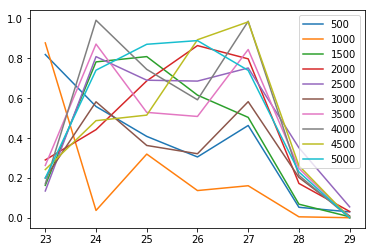

In [203]:
# Mann-Whitney U test for each day
# 分别看每一天的U-test,在不同大小的top子集上，可发现最前面（freq）的词语rank相类似，后续词语不同
from scipy import stats
mw_ = {}
for i in range(500,5500,500):
    u_test=[]
    for d in dates:
        u_test.append(stats.mannwhitneyu(list(tweets_words_dicts_2g[d].keys())[:i],list(news_words_dicts_2g[d].keys())[:i],alternative='two-sided')[1])
    mw_[i] = u_test
# 假设：假设两个独立样本之间没有差异，成立则H0，不成立则H1
# 若p值小于0.05，拒绝H0，故可以认为有显著差异。反之，p>0.05,无差异
# The Mann-Whitney U test null hypothesis (H0) stipulates that the two groups come from the same population.
pd.DataFrame(mw_, index=dates).plot() 

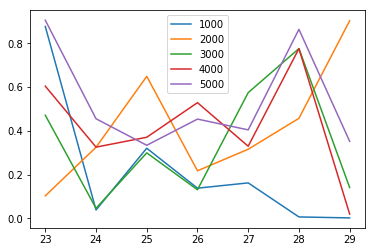

In [205]:
# stacked top-words
from scipy import stats
mw_ = {}
for i in range(1000,6000,1000):
    u_test=[]
    for d in dates:
        u_test.append(stats.mannwhitneyu(list(tweets_words_dicts_2g[d].keys())[i-1000:i],list(news_words_dicts_2g[d].keys())[i-1000:i],alternative='two-sided')[1])
    mw_[i] = u_test
# 假设：假设两个独立样本之间没有差异，成立则H0，不成立则H1
# 若p值小于0.05，拒绝H0，故可以认为有显著差异。反之，p>0.05,无差异
# The Mann-Whitney U test null hypothesis (H0) stipulates that the two groups come from the same population.
pd.DataFrame(mw_, index=dates).plot() 

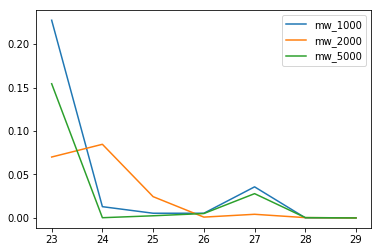

In [159]:
pd.DataFrame({'mw_1000':mw_1000,'mw_2000':mw_2000,'mw_5000':mw_5000}, index=dates).plot() # old one

In [206]:
# Total words dict (rank) in one-week among both datasets
total_wd_tweets, total_wd_news, total_wd = nltk.FreqDist(),nltk.FreqDist(),nltk.FreqDist()
for d in dates:
    total_wd_tweets += tweets_words_dicts_2g[d]
    total_wd_news += news_words_dicts_2g[d]
total_wd = total_wd_tweets+total_wd_news
total_wd

FreqDist({'corona virus': 567221, 'new york': 201295, 'social distance': 183844, 'stay home': 174000, 'coronavirus pandemic': 169574, 'test positive': 136039, 'public health': 127894, 'coronavirus outbreak': 108568, 'last week': 104714, 'prime minister': 98470, ...})

In [207]:
# News, Top 2000 words in each day
dfs = [pd.DataFrame(list(news_words_dicts_2g[d].keys())[:2000],columns=['Mar_{} '.format(d)]) for d in dates]
df_words_dict = pd.concat(dfs,axis=1)
df_words_dict

,Mar_23,Mar_24,Mar_25,Mar_26,Mar_27,Mar_28,Mar_29
0,social distance,social distance,new york,new york,new york,new york,new york
1,new york,coronavirus pandemic,coronavirus pandemic,coronavirus pandemic,coronavirus pandemic,coronavirus pandemic,coronavirus pandemic
2,coronavirus pandemic,new york,social distance,social distance,social distance,social distance,social distance
3,stay home,stay home,stay home,public health,test positive,test positive,test positive
4,public health,public health,public health,stay home,public health,public health,stay home
...,...,...,...,...,...,...,...
1995,gaza strip,business worker,nearly million,institute health,view post,steven mnuchin,virus infect
1996,global market,state parks,need test,business need,aid relief,time since,euro million
1997,rural area,two hours,health concern,chief financial,labor department,coronavirus state,say concern
1998,people like,central government,starting march,chinese government,report confirm,edt march,member family


In [208]:
df_news_2g = df_words_dict.unstack().reset_index(name='2g-words')
df_news_2g.rename(columns={'level_0': 'dates', 'level_1': 'ranks'}, inplace=True)                                                                                                          
df_news_2g_ranks = pd.concat([pd.DataFrame(df_news_2g.groupby('2g-words').apply(lambda x: list(x['ranks'])),columns=['ranks']),
pd.DataFrame(df_news_2g.groupby('2g-words').apply(lambda x: list(x['dates'])),columns=['dates'])],axis=1)

df_news_2g_ranks.reindex(total_wd_news).head(30)

,ranks,dates
2g-words,,
new york,"[1, 2, 0, 0, 0, 0, 0]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
coronavirus pandemic,"[2, 1, 1, 1, 1, 1, 1]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
social distance,"[0, 0, 2, 2, 2, 2, 2]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
stay home,"[3, 3, 3, 4, 5, 5, 4]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
public health,"[4, 4, 4, 3, 4, 4, 6]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
test positive,"[5, 8, 5, 7, 3, 3, 3]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
coronavirus outbreak,"[7, 6, 6, 6, 8, 6, 8]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
last week,"[6, 5, 7, 5, 11, 17, 10]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
unite state,"[12, 10, 9, 8, 7, 8, 9]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."


In [209]:
# Tweets 
dfs = [pd.DataFrame(list(tweets_words_dicts_2g[d].keys())[:2000],columns=['Mar_{} '.format(d)]) for d in dates]
df_words_dict = pd.concat(dfs,axis=1)
df_words_dict

,Mar_23,Mar_24,Mar_25,Mar_26,Mar_27,Mar_28,Mar_29
0,corona virus,corona virus,corona virus,corona virus,corona virus,corona virus,corona virus
1,stay home,stay home,get corona,get corona,get corona,fight corona,fight corona
2,get corona,get corona,stay home,stay home,stay home,get corona,get corona
3,fight corona,fight corona,fight corona,fight corona,fight corona,stay home,stay home
4,rampal ji,due corona,due corona,due corona,due corona,due corona,due corona
...,...,...,...,...,...,...,...
1995,corona tweet,mark beast,fight back,lmao corona,virus become,chris mann,people please
1996,know one,subscribe channel,focus corona,predict corona,want people,coronaupdate coronavirus,take precaution
1997,lmao corona,manu dibango,know going,corona govt,sant shri,political party,narendramodi arvindkejriwal
1998,saintrampaljim end,proper perspective,sir pls,boost immune,virus bring,indian boy,arvindkejriwal corona


In [210]:
df_tweets_2g = df_words_dict.unstack().reset_index(name='2g-words')
df_tweets_2g.rename(columns={'level_0': 'dates', 'level_1': 'ranks'}, inplace=True)                                                                                                          
df_tweets_2g = pd.concat([pd.DataFrame(df_tweets_2g.groupby('2g-words').apply(lambda x: list(x['ranks'])),columns=['ranks']),
pd.DataFrame(df_tweets_2g.groupby('2g-words').apply(lambda x: list(x['dates'])),columns=['dates'])],axis=1)

df_tweets_2g.reindex(total_wd_tweets).head(30)

,ranks,dates
2g-words,,
corona virus,"[0, 0, 0, 0, 0, 0, 0]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
get corona,"[2, 2, 1, 1, 1, 2, 2]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
stay home,"[1, 1, 2, 2, 2, 3, 3]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
fight corona,"[3, 3, 3, 3, 3, 1, 1]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
due corona,"[5, 4, 4, 4, 4, 4, 4]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
gon na,"[6, 5, 5, 5, 5, 5, 5]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
corona corona,"[10, 7, 7, 6, 7, 6, 6]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
stay safe,"[9, 6, 9, 9, 9, 10, 8]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
corona shit,"[11, 9, 8, 8, 11, 7, 7]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."


In [211]:
df_tweets_2g.reindex(total_wd_news).head(30)

,ranks,dates
2g-words,,
new york,"[205, 156, 48, 49, 59, 77, 86]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
coronavirus pandemic,"[350, 373, 308, 293, 249, 377, 442]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
social distance,"[13, 10, 11, 12, 12, 12, 10]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
stay home,"[1, 1, 2, 2, 2, 3, 3]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
public health,"[707, 604, 649, 668, 627, 894, 1554]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
test positive,"[28, 32, 13, 13, 6, 16, 22]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
coronavirus outbreak,"[397, 459, 505, 462, 561, 834, 734]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
last week,"[173, 191, 184, 204, 208, 287, 301]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."
unite state,"[384, 443, 400, 388, 327, 314, 316]","[Mar_23 , Mar_24 , Mar_25 , Mar_26 , Mar_27 , ..."


# 2-gram overlap words
in most common words (max 5000)

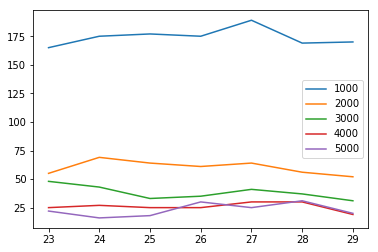

In [212]:
# show overlap words each day against different topN subset
overlap_counts_2g = {}
for i in range(1000,6000,1000):
    overlap_counts=[]
    for d in dates:
        overlap_counts.append(len([tk for tk in list(tweets_words_dicts_2g[d].keys())[i-1000:i] if tk in list(news_words_dicts_2g[d].keys())[i-1000:i]]))
    overlap_counts_2g[i] = overlap_counts
pd.DataFrame(overlap_counts_2g, index=dates).plot()

In [213]:
overlap_counts_1k = [len([tk for tk in list(tweets_words_dicts_2g[d].keys())[:1000] if tk in list(news_words_dicts_2g[d].keys())[:1000]]) for d in dates]
overlap_counts_1k

[165, 175, 177, 175, 189, 169, 170]

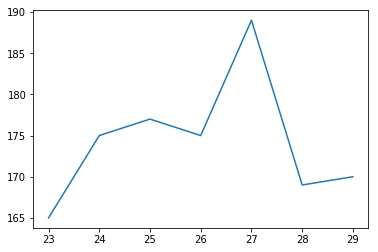

In [214]:
pd.Series(overlap_counts_1k,index=dates).plot()

In [215]:
overlap_counts_2k = [len([tk for tk in list(tweets_words_dicts_2g[d].keys())[:2000] if tk in list(news_words_dicts_2g[d].keys())[:2000]]) for d in dates]
overlap_counts_2k

[367, 405, 396, 397, 410, 383, 362]

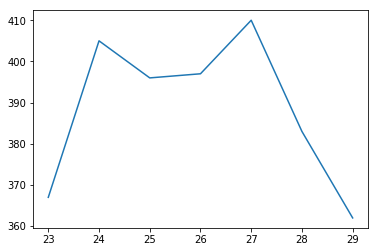

In [216]:
pd.Series(overlap_counts_2k,index=dates).plot()

In [217]:
overlap_counts_5k = [len([tk for tk in list(tweets_words_dicts_2g[d].keys())[:5000] if tk in list(news_words_dicts_2g[d].keys())[:5000]]) for d in dates]
overlap_counts_5k

[1040, 1102, 1112, 1127, 1157, 1073, 997]

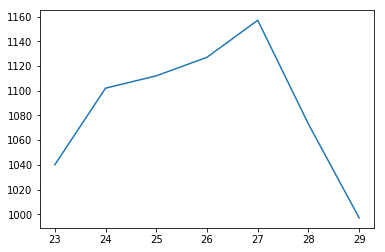

In [218]:
pd.Series(overlap_counts_5k,index=dates).plot()

In [219]:
# one-week overlap words, total appears times in both dataset
ol_words_dict = nltk.FreqDist()
for tk in list(total_wd_tweets.keys()):
    if tk in list(total_wd_news.keys()):
        ol_words_dict[tk] = [total_wd_tweets[tk],total_wd_news[tk]]
ol_words_dict

FreqDist({'corona virus': [552137, 15084], 'stay home': [45393, 128607], 'gon na': [27340, 6925], 'stay safe': [22086, 15060], 'social distance': [18667, 165177], 'test positive': [16743, 119296], 'prime minister': [9715, 88755], 'virus pandemic': [9693, 2650], 'prince charles': [9124, 9374], 'total death': [8342, 3693], ...})

In [220]:
for d in dates:
    print([i[0] for i in news_words_dicts_2g[d].most_common(5000)]==list(news_words_dicts_2g[d].keys())[:5000] and [i[0] for i in tweets_words_dicts_2g[d].most_common(5000)]==list(tweets_words_dicts_2g[d].keys())[:5000])    

True
True
True
True
True
True
True


In [221]:
[i[0] for i in words.most_common(2000)] == list(words.keys())[:2000]

False

In [227]:
# 一周overlap词 （2000, min:Top164）, 根据tweets和news出现总数排序
ol_words = {}
for d in dates:
    words = nltk.FreqDist()
    for tk in list(tweets_words_dicts_2g[d].keys())[:2000]:
        if len(words) >= min(overlap_counts_2k):
            break
        else:
            if tk in list(news_words_dicts_2g[d].keys())[:2000]:
                words[tk] = tweets_words_dicts_2g[d][tk] + news_words_dicts_2g[d][tk]
    ol_words[d] = [[i[0],'{}+{}'.format(news_words_dicts_2g[d][i[0]],tweets_words_dicts_2g[d][i[0]])] for i in words.most_common()] # show details for testing
#     ol_words[d] = [i[0] for i in words.most_common()] 
df_ol = pd.DataFrame(ol_words)
df_ol.head(50)

,23,24,25,26,27,28,29
0,"[corona virus, 2553+83890]","[corona virus, 2695+90036]","[corona virus, 2311+78954]","[corona virus, 2197+80871]","[corona virus, 2118+125768]","[corona virus, 1855+67141]","[corona virus, 1355+25477]"
1,"[social distance, 28265+2967]","[stay home, 24406+8852]","[new york, 32154+1130]","[new york, 31107+1086]","[new york, 32228+1642]","[new york, 27432+803]","[new york, 18029+312]"
2,"[stay home, 23619+7146]","[social distance, 28705+3092]","[social distance, 29186+2535]","[social distance, 27450+2538]","[social distance, 25029+4217]","[social distance, 16543+2370]","[social distance, 9999+948]"
3,"[new york, 25991+544]","[new york, 28166+671]","[coronavirus pandemic, 29953+402]","[coronavirus pandemic, 29352+420]","[test positive, 21794+5845]","[stay home, 12139+4885]","[coronavirus pandemic, 10387+113]"
4,"[coronavirus pandemic, 25282+385]","[coronavirus pandemic, 28382+401]","[stay home, 23039+6465]","[stay home, 19914+6609]","[coronavirus pandemic, 26796+697]","[coronavirus pandemic, 16678+326]","[stay home, 8340+2000]"
5,"[test positive, 19960+1760]","[public health, 23241+294]","[test positive, 21161+2453]","[public health, 20289+242]","[stay home, 17150+9436]","[test positive, 14339+1865]","[test positive, 9430+639]"
6,"[last week, 19656+608]","[last week, 20568+601]","[public health, 22952+246]","[test positive, 17268+2509]","[public health, 18926+397]","[public health, 13133+185]","[prime minister, 7775+460]"
7,"[public health, 19969+241]","[coronavirus outbreak, 19002+353]","[coronavirus outbreak, 18497+299]","[last week, 18296+509]","[prime minister, 15372+2719]","[coronavirus outbreak, 11225+194]","[public health, 7732+47]"
8,"[coronavirus outbreak, 17826+353]","[prime minister, 16927+1670]","[last week, 18127+525]","[coronavirus outbreak, 17998+314]","[health care, 16073+702]","[confirm case, 10609+480]","[confirm case, 7245+153]"
9,"[prime minister, 13904+1733]","[test positive, 15344+1672]","[health care, 15934+434]","[unite state, 15920+354]","[unite state, 15836+607]","[unite state, 10337+369]","[coronavirus outbreak, 6624+81]"


In [223]:
total_wd

FreqDist({'corona virus': 567221, 'new york': 201295, 'social distance': 183844, 'stay home': 174000, 'coronavirus pandemic': 169574, 'test positive': 136039, 'public health': 127894, 'coronavirus outbreak': 108568, 'last week': 104714, 'prime minister': 98470, ...})

In [224]:
df_ol_dict = df_ol.unstack().reset_index(name='2g-words')
df_ol_dict.rename(columns={'level_0': 'dates', 'level_1': 'ranks'}, inplace=True)                                                                                                          
df_ol_dict = pd.concat([pd.DataFrame(df_ol_dict.groupby('2g-words').apply(lambda x: list(x['ranks'])),columns=['ranks']),
            pd.DataFrame(df_ol_dict.groupby('2g-words').apply(lambda x: list(x['dates'])),columns=['dates'])],axis=1)

df_ol_dict = df_ol_dict.reindex(total_wd).dropna()
df_ol_dict.loc[:,'day_count'] = [len(r) for r in df_ol_dict.dates]
df_ol_dict.head(30)

,ranks,dates,day_count
2g-words,,,
corona virus,"[0, 0, 0, 0, 0, 0, 0]","[23, 24, 25, 26, 27, 28, 29]",7
new york,"[3, 3, 1, 1, 1, 1, 1]","[23, 24, 25, 26, 27, 28, 29]",7
social distance,"[1, 2, 2, 2, 2, 2, 2]","[23, 24, 25, 26, 27, 28, 29]",7
stay home,"[2, 1, 4, 4, 5, 3, 4]","[23, 24, 25, 26, 27, 28, 29]",7
coronavirus pandemic,"[4, 4, 3, 3, 4, 4, 3]","[23, 24, 25, 26, 27, 28, 29]",7
test positive,"[5, 9, 5, 6, 3, 5, 5]","[23, 24, 25, 26, 27, 28, 29]",7
public health,"[7, 5, 6, 5, 6, 6, 7]","[23, 24, 25, 26, 27, 28, 29]",7
coronavirus outbreak,"[8, 7, 7, 8, 10, 7, 9]","[23, 24, 25, 26, 27, 28, 29]",7
last week,"[6, 6, 8, 7, 12, 15, 11]","[23, 24, 25, 26, 27, 28, 29]",7


In [225]:
df_ol_dict.day_count.value_counts()

7    223
1    139
2     62
6     48
3     45
4     38
5     27
Name: day_count, dtype: int64

In [226]:
df_ol_dict.sort_values(by='day_count', ascending=False).head(54)

,ranks,dates,day_count
2g-words,,,
corona virus,"[0, 0, 0, 0, 0, 0, 0]","[23, 24, 25, 26, 27, 28, 29]",7
family friend,"[147, 193, 183, 186, 188, 190, 196]","[23, 24, 25, 26, 27, 28, 29]",7
south african,"[112, 176, 199, 179, 152, 162, 147]","[23, 24, 25, 26, 27, 28, 29]",7
relief fund,"[323, 232, 241, 161, 114, 85, 101]","[23, 24, 25, 26, 27, 28, 29]",7
give us,"[177, 165, 167, 162, 133, 160, 213]","[23, 24, 25, 26, 27, 28, 29]",7
take action,"[150, 145, 154, 157, 178, 191, 259]","[23, 24, 25, 26, 27, 28, 29]",7
current situation,"[179, 173, 147, 172, 159, 151, 216]","[23, 24, 25, 26, 27, 28, 29]",7
stay away,"[130, 177, 164, 169, 180, 168, 191]","[23, 24, 25, 26, 27, 28, 29]",7
precautionary measure,"[122, 160, 173, 168, 213, 217, 166]","[23, 24, 25, 26, 27, 28, 29]",7


In [228]:
df_ol.to_csv('overlap_words_unique.csv')
df_ol_dict.to_csv('overlap_words_ranking_unique.csv')